In [7]:
!gdown --id 1MxCUvKxejnwWnoZ-KoCyMCXo3TLhRuTo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MxCUvKxejnwWnoZ-KoCyMCXo3TLhRuTo
To: /content/viton_resize.tar.gz
100% 239M/239M [00:03<00:00, 68.2MB/s]


In [45]:
import tarfile
# open file
file = tarfile.open('/content/viton_resize.tar.gz', "r:gz")
# extracting file
file.extractall('/content/')
file.close()

In [18]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-jcs3826_
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-jcs3826_
  Created wheel for tensorflow-examples: filename=tensorflow_examples-4943ea2bef5b5c51a9cf60514c799004d104dcb7_-py3-none-any.whl size=299301 sha256=7803f83c3fab8e01654cb0f486bb51df5c1c9634b0a0152a852dfd421cd5d430
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jne8ci6/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [100]:
import pathlib
train_data_dir = pathlib.Path("/content/viton_resize/train/")
test_data_dir = pathlib.Path("/content/viton_resize/test/")

In [199]:
train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))

print(train_image_count, test_image_count)

14221 2032


In [200]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [255]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  # validation_split=0.5,
  # subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 14221 files belonging to 1 classes.


In [256]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  # validation_split=0.5,
  # subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2032 files belonging to 1 classes.


In [257]:
split_train_ds = floor(len(train_ds) * .5)
split_val_ds = floor(len(val_ds) * .5)
train_modelA = train_ds.take(split_train_ds)
train_modelB = train_ds.skip(split_train_ds)
test_modelA = val_ds.take(split_val_ds)
test_modelB = val_ds.skip(split_val_ds)

In [286]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [259]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [260]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [261]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [262]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [263]:
train_modelA = train_modelA.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_modelB = train_modelB.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_modelA = test_modelA.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_modelB = test_modelB.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [273]:
sample_modelA = next(iter(train_modelA))
sample_modelB = next(iter(train_modelB))

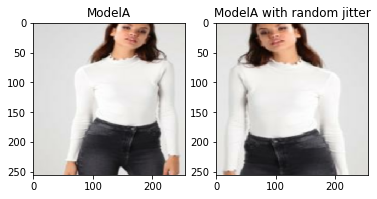

In [265]:
# image = batch[0]                  #remove astype('uint8')
# # plot raw pixel data
# plt.imshow(np.squeeze(image))     #r
plt.subplot(121)
plt.title('ModelA')
plt.imshow(np.squeeze(sample_modelA[0]) * 0.5 + 0.5)

plt.subplot(122)
plt.title('ModelA with random jitter')
plt.imshow(np.squeeze(random_jitter(sample_modelA[0])) * 0.5 + 0.5)

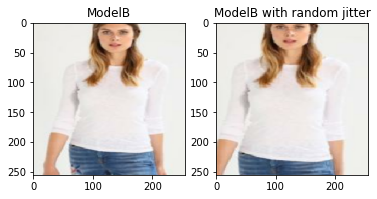

In [266]:
plt.subplot(121)
plt.title('ModelB')
plt.imshow(np.squeeze(sample_modelB[0]) * 0.5 + 0.5)

plt.subplot(122)
plt.title('ModelB with random jitter')
plt.imshow(np.squeeze(random_jitter(sample_modelB[0])) * 0.5 + 0.5)

In [267]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [274]:
to_ModelB = generator_g(sample_modelA)
to_ModelA = generator_f(sample_modelB)
plt.figure(figsize=(8, 8))
contrast = 8
#sample_modelA, to_ModelB, sample_modelB, to_ModelA
imgs = [sample_modelA, to_ModelB, sample_modelB, to_ModelA]
title = ['sample_modelA', 'to_ModelB', 'sample_modelB', 'to_ModelA']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

ValueError: ignored

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))